# Market Condition DRL Analysis

This notebook evaluates DQN, PPO, and A2C under different simulated market conditions: bull, bear, and volatile markets.

In [1]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load cleaned dataset
df = pd.read_csv("cleaned_stock_data.csv")
for col in df.columns:
    if "close" in col.lower():
        df.rename(columns={col: "Close"}, inplace=True)
        break
df.dropna(inplace=True)

# Define market regimes
bull_df = df[df['Close'] > df['Close'].rolling(30).mean()]
bear_df = df[df['Close'] < df['Close'].rolling(30).mean()]
volatile_df = df[(df['Close'].pct_change().abs() > 0.02)]

In [3]:
# Define trading environment
class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.max_steps = len(df) - 1
        self.current_step = 0
        self.action_space = spaces.Discrete(3)  # Hold, Buy, Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(df.select_dtypes(include=np.number).shape[1],), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        return self.df.select_dtypes(include=np.number).iloc[self.current_step].values.astype(np.float32)

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        reward = 0
        if action == 1:  # Buy
            reward = self.df['Close'].iloc[self.current_step] - self.df['Close'].iloc[self.current_step - 1]
        elif action == 2:  # Sell
            reward = self.df['Close'].iloc[self.current_step - 1] - self.df['Close'].iloc[self.current_step]
        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Price: {self.df['Close'].iloc[self.current_step]}")

In [4]:
# Function to train and evaluate DRL models on a market condition
def run_drl_on_condition(market_df, title):
    env = DummyVecEnv([lambda: StockTradingEnv(market_df)])
    models = {
        'DQN': DQN('MlpPolicy', env, verbose=0),
        'PPO': PPO('MlpPolicy', env, verbose=0),
        'A2C': A2C('MlpPolicy', env, verbose=0)
    }
    rewards = {}
    for name, model in models.items():
        model.learn(total_timesteps=10000)
        obs = env.reset()
        done = False
        cum_rewards = []
        total_reward = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward[0]
            cum_rewards.append(total_reward)
        rewards[name] = cum_rewards

    # Plot results
    plt.figure(figsize=(10,6))
    for name, reward_list in rewards.items():
        plt.plot(reward_list, label=name)
    plt.title(f"Cumulative Rewards - {title} Market")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

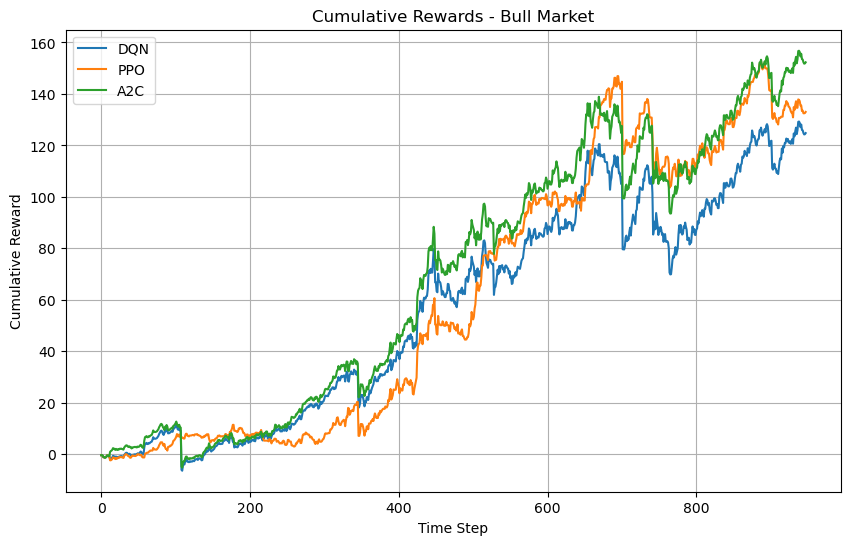

In [5]:
run_drl_on_condition(bull_df, "Bull")

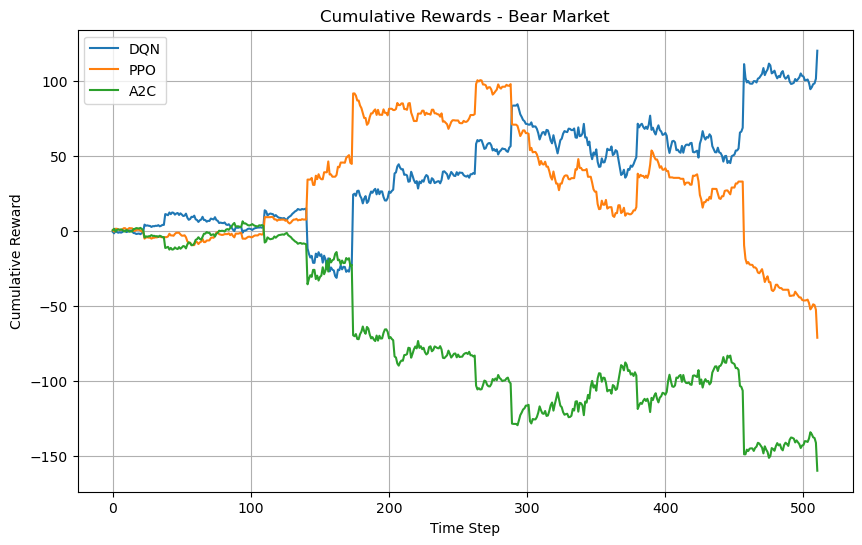

In [6]:
run_drl_on_condition(bear_df, "Bear")

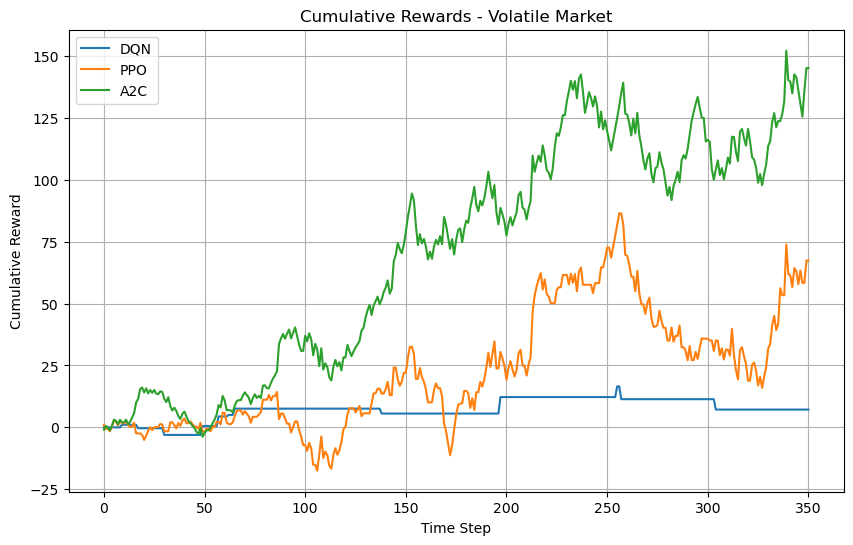

In [7]:
run_drl_on_condition(volatile_df, "Volatile")